![DSME-logo](./img/DSME_logo.png)

#  Reinforcement Learning and Learning-based Control

<p style="font-size:12pt";> 
<b> Prof. Dr. Sebastian Trimpe, Dr. Friedrich Solowjow </b><br>
<b> Institute for Data Science in Mechanical Engineering (DSME) </b><br>
<a href = "mailto:rllbc@dsme.rwth-aachen.de">rllbc@dsme.rwth-aachen.de</a><br>
</p>

---

# TD-Methods vs. MC-Methods for Control

## Library Imports

In [12]:
import time
import warnings
from collections import defaultdict
from IPython.display import Video
from IPython.display import display
import numpy as np
import custom_envs
import gymnasium as gym
from tqdm import notebook
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

## Initializations

We compare two different types of methods: TD methods, represented by SARSA, and MC methods, represented by First-Visit Monte-Carlo Control. We use the methods to train agents, whereupon we compare the results and the reward achieved during sampling. For the comparison of both methods, the environment "FrozenLake" is used, in which an agent has to find the correct path through a grid world. An example is shown below.

<img src="./img/frozen_lake.gif" alt="Environment" width="800" />

Both methods gain experience from training with an &epsilon;-greedy policy, where the action is either random or determined based on an action value function. Learning the value function is iterative so that the policy continues to improve over time. Monte Carlo methods perform updates of the action value function based on the full episode. In contrast, TD methods perform updates during sampling. 

### Agent Class

First, we design the class `Agent`. The class consists of the action value function, which is used to select actions. To select the actions during training, we use an &epsilon;-greedy policy. For this purpose, the class `Agent` has the method`epsilon_greedy_policy`, which calls the method `get_random_action` with a probability `epsilon` of choosing a random action. Otherwise, the agent uses the action that promises the maximum reward via `get_best_action`. This way, additional experience can be generated despite greedy sampling. Sampling from the optimal policy can happen by only using `get_best_action` after training.


In [13]:
class Agent():
    def __init__(self, env, gamma=0.9, epsilon=0.1, learning_rate=0.05):
        self.env = env
        self.action_value_fn = np.zeros((self.env.observation_space.n, self.env.action_space.n))
        self.gamma = gamma 
        self.epsilon = epsilon 
        self.rtol = 0.08
        # Only necessary for first-visit MC:
        self.returns = defaultdict(float) 
        self.returns_count = defaultdict(float)
        # Only necessary for SARSA
        self.learning_rate = learning_rate

    def get_random_action(self):
        random_action = np.random.choice(range(self.env.action_space.n))
        return random_action
    
    def get_best_action(self, obs):
        best_action = np.random.choice(np.flatnonzero(np.isclose(self.action_value_fn[obs], self.action_value_fn[obs].max(),
                                                                 self.rtol))) 
        return best_action
    
    def epsilon_greedy_policy(self, obs):
        randomly = np.random.random() < self.epsilon
        if randomly:
            action = self.get_random_action()
        else:
            action = self.get_best_action(obs)
        return action

A special feature of the implementation is that in the case of similar action values for several actions (based on a tolerance `self.rtol`) in a state, these actions are chosen randomly. To keep the resulting policy performant, a discount factor `self.gamma` is used. 

Next, we add the two algorithms used for learning. Both algorithms use the parameter `num_episodes`, which defines the number of episodes until the end of the training. At the end of the training, the training methods return an array containing the total reward achieved in the episodes so that they can be compared.

### MC-Method - First-Visit Monte Carlo

In Monte Carlo methods, the evaluation of state and action pairs is performed based on completed episodes. In First-Visit methods, the action value of a state is calculated as the average return over all episodes in which the state-action pair was visited for the first time. This method guarantees that each visit is scored only once, preventing double weighting of episodes that visit the same state-action pair. Beyond that, there exist Every-Visit methods, in which each passing through a state-action pair is evaluated. An overview of the algorithm is provided below:

<img src="./img/first_visit_MC.png" alt="First-Visit MC" width="500" />

The training is realized in the `first_visit_MC` method. By using the learning method, the action value function of the class `Agent` is improved over episodes. Based on this, the resulting policy is also improved with each episode. It is worth noting that the policy updates happen implicitly through the use of the `epsilon_greedy_policy` method.

In [14]:
def first_visit_MC(self, num_episodes=2000):
    returns_log = [] # Used for logging
    # Run through episodes sampled to improve policy incrementally
    for i_episode in range(1, num_episodes + 1):
        # Generate an episode (state, action, reward)
        episode = []
        returns_i = 0
        obs, info = env.reset()
        done = False
        while not done:
            action = self.epsilon_greedy_policy(obs)
            next_obs, reward, done, truncated, info = env.step(action)
            episode.append((obs, action, reward))
            returns_i += reward
            obs = next_obs
        returns_log.append(returns_i)
        episode = np.array(episode)
        episode_duration = len(episode[:,:1])
        # Calculate returns for the whole episode from the back to save memory and resources
        G = np.zeros([episode_duration, ])
        for i in range(episode_duration - 1, -1, -1):
            if i + 1 > episode_duration - 1:
                G[i] = episode[i][2]
            else:
                G[i] = episode[i][2] + self.gamma * G[i + 1]
        # Find indices of first visits of state-action pairs in the episode
        first_visit_indices = sorted(np.unique(episode[:,:1], return_index=True)[1])
        # Update the policy with average over all episodes
        for index in first_visit_indices:
            state = episode[index][0]
            action = episode[index][1]
            self.returns[(state, action)] += G[index]
            self.returns_count[(state, action)] += 1.0
            update = self.returns[(state, action)] / self.returns_count[(state, action)]
            self.action_value_fn[int(state)][int(action)] = update
    return returns_log

setattr(Agent, "first_visit_MC", first_visit_MC)

### TD-Method - SARSA

Temporal Difference (TD) learning methods update the action value function without having to finish the episode. SARSA stands for "State-Action-Reward-State-Action". It is an on-policy form of TD-learning, since it updates its action values using the action value of the next state and the current policies action. An off-policy alternative is Q-learning, where action values are updated using the action value of the next state and a greedy action (`get_best_action`). An overview of the algorithm is provided below:

<img src="./img/sarsa.png" alt="First-Visit MC" width="500" />

The algorithm is implemented in the `sarsa` method. As for `first_visit_MC`, the implementation follows lecture 5.

In [15]:
def sarsa(self, num_episodes=2000):
    returns_log = [] # Used for logging
    # Run through episodes
    for i in range(num_episodes):
        returns_i = 0
        obs, info = env.reset()
        action = self.epsilon_greedy_policy(obs)
        done = False
        while not done:
            # In each step, update the action value function
            next_obs, reward, done, truncated, info = env.step(action)
            next_action = self.epsilon_greedy_policy(next_obs)
            td_target = reward + self.gamma * self.action_value_fn[next_obs][next_action]
            update = (1-self.learning_rate) * self.action_value_fn[obs][action] + self.learning_rate * td_target
            self.action_value_fn[obs][action] = update
            obs = next_obs
            action = next_action
            returns_i += reward
        returns_log.append(returns_i)
    return returns_log

setattr(Agent, "sarsa", sarsa)

This defines both agents so that they can be trained.

## Training the Agents 

For this purpose, the environment "FrozenLake" is used, and a map is defined. In the environment, the goal is to choose correct movements on a grid for reaching a gift. Reaching the gift generates a reward of "1", while falling into a hole causes the episode to end without a reward.

We define a `map` for the environment and initially do not use `render_mode` to speed up the training. In addition, we set `is_slippery = False` to prevent agents from moving randomly. After initializing the environment, necessary parameters are defined, followed by creating the agents and training them.

In [16]:
# Initialize environment
map = ["SFFH", "FFFH", "HFFH", "HFFG"]
env = gym.make('CustomFrozenLake-v1', render_mode=None, desc=map, is_slippery=False) # render mode is None to speed up learning
env.reset()

# Parameters
gamma = 0.9
epsilon = 0.1
learning_rate = 0.1
train_episodes = 2000

# Initialize agents
mc_agent = Agent(env, gamma, epsilon)
td_agent = Agent(env, gamma, epsilon, learning_rate)

# Train agents
mc_training_history = mc_agent.first_visit_MC(train_episodes)
td_training_history = td_agent.sarsa(train_episodes)

### Comparing the Acheived Rewards during Training

The achieved total rewards of the episodes during the training are shown below above the episodes. Since the reward can be either "1" or "0", we use the `smooth` method that gives the mean over a number of episodes defined by the `size` parameter.

In [17]:
def smooth(array, size):
    window_size = size
    filter = np.ones(window_size) / window_size
    smoothed_array = np.convolve(array, filter, mode='same')
    return smoothed_array

Using this method results in the following graphs for the achieved reward:

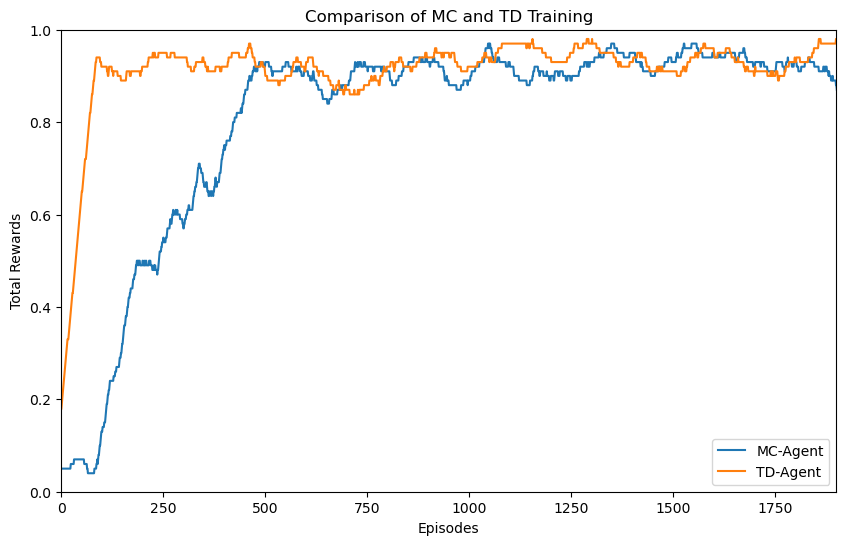

In [18]:
# Set the size for smoothing
size = 100

# Compare the returns
fig, ax = plt.subplots(figsize=(10, 6))  # Create a figure and an axes.
ax.plot(range(train_episodes), smooth(mc_training_history, size), label="MC-Agent")
ax.plot(range(train_episodes), smooth(td_training_history, size), label="TD-Agent")
ax.grid(False)
ax.set_xlabel('Episodes')
ax.set_ylabel('Total Rewards')
ax.set_title("Comparison of MC and TD Training")
ax.set_ylim(0, 1)
ax.set_xlim(0, train_episodes-size)
ax.legend()
plt.show()

Now we can evaluate the final policy.

## Comparing the Trained Agents

For this purpose, we add another method to the `Agent` class, which can be used to display the policy. This method `evaluate` lets the agent sample the best possible actions for a number of episodes based on the `num_runs` parameter, using `get_best_action`. A video is recorded, which is returned.

In [19]:
def evaluate(self, env, num_runs=10, file=None):
    frames = []  # collect rgb_image of agent env interaction
    video_created = False
    for _ in range(num_runs):
        done = False
        obs, info = env.reset()
        reward_per_run = 0
        out = env.render()
        frames.append(out)
        while not done:
            action = self.get_best_action(obs)
            obs, reward, done, truncated, info = env.step(action)
            reward_per_run += reward
            # save frame
            out = env.render()
            frames.append(out)

    # create animation out of saved frames
    if all(frame is not None for frame in frames):
        fig = plt.figure(figsize=(10, 6))
        plt.axis('off')
        img = plt.imshow(frames[0])

        def animate(index):
            img.set_data(frames[index])
            return [img]
        anim = FuncAnimation(fig, animate, frames=len(frames), interval=20)
        plt.close()
        anim.save(file, writer="ffmpeg", fps=5)
        video_created = True

    return video_created

setattr(Agent, "evaluate", evaluate)

To display the policies, first, the `render_mode` of the environment must be changed so that a rgb array can be stored. To achieve this, we replace the current environment. Additionally, we define the number of runs we want to use for evaluation.

In [20]:
# Switching the render_mode to rgb_array
env = gym.make('CustomFrozenLake-v1', render_mode='rgb_array', desc=map, is_slippery=False)

# Defining the number of runs for the evaluation
num_runs = 10

We now use the `evaluate` method to store and replay a video for both agents, displaying the policies on the grid.

### Policy of the MC-Agent

In [21]:
mc_video_file = "mc_trained.mp4"
mc_agent.evaluate(env, num_runs, mc_video_file)
Video(mc_video_file, html_attributes="loop autoplay")

### Policy of the TD-Agent

In [22]:
td_video_file = "td_trained.mp4"
td_agent.evaluate(env, num_runs, td_video_file)
Video(td_video_file, html_attributes="loop autoplay")